## 1. Import tools

In [1]:
import sys
sys.path.append('/g/g92/miao1/Development/llsmvis')
sys.path.append('/Users/yi10/Desktop/Research/Software/T-llsmvis/')
sys.path.append('/g/g92/yi10')
import llsmvis
from llsmvis.extensions import hp3d
from llsmvis.extensions.hp3d import surface_morphometrics as sm
from llsmvis.extensions.hp3d import masscenter as mc
import os
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import vtk
from vtk.util import numpy_support
from llsmvis.extensions.hp3d import tools_vectorsets as v
from scipy.interpolate import griddata

%load_ext autoreload
%autoreload 2

Loading BokehJS ...

## 2. Define parameters

In [2]:
apex_angle=40 # apex angle of the cone, degree.
# fnorm_for_cone=sm.get_f_norm(40)
fnorm_for_cone=1
sample_angle=15 # sampling angle when choose semi-equal spaced points.
outputpath='/p/lscratchh/yi10/hp3d/cones/cones_CenterSpacingAngle'+str(sample_angle)+'_ConeApexAngle'+str(apex_angle)
try:
    os.mkdir(outputpath)
except:
    pass
height=150
# define testing data paths
# output dir
output_dir = '/p/lscratchh/yi10/tmp4'
try:
    os.mkdir(output_dir)
except:
    pass
# shifted cell stl
shiftedcellstl=os.path.join(output_dir,'shiftedcell.stl')
# shiftedcellstl="/p/lscratchh/yi10/tmp4/sphere.stl"

# input cellstlpath
cellstlpath='/p/lscratchh/yi10/hp3d/2021-11-10-cell1/surface_extraction/Trimmed_cell1_Iter_ch0_stack0000_3nm_0000000msec_0002613822msecAbs320.0_10.stl'
# get shifted cell stl
sm.get_shifted_cell(cellstlpath,output=shiftedcellstl,savestl=True)

# Define equaliy spaced vectors to be used as the direcitonal vector for the cones
xs,ys,zs=v.sample_points_semi_equal_space(sample_angle)
print("total number of points: " +str(len(xs)))

# define mapping interpolation coordinates
# make the current location coordinates into the format of points for interpolation
points=np.asarray([xs,ys,zs]).T

# define location points to interpolate for
request=v.sample_points_equal_spaced_logi_lati(longitude_n=360, latitude_n=180).T

# define all cone stl paths
coneind=0
conestlpaths=[]
for x,y,z in zip(xs, ys, zs):
    conestlpath=os.path.join(outputpath,'cone_pos'+str(coneind)+'.stl')
    conestlpaths.append(conestlpath)
    coneind+=1


<vtkmodules.vtkCommonDataModel.vtkPolyData(0x555557ebb590) at 0x2aaafcc94c20>

total number of points: 184


## 3. Perform patch-wise r/v calculations
calculate the patch-wise roughness and volumes as cropped by cones

In [3]:
# loop over each cone, extract patch wise roughness and volume with all the cone-cuts
d={}
d.update({'content':'patch wise roughness and cone volume analysis results for one 3D volume'})

roughnesses=[]
conevolumes=[]
for cone_index in np.arange(0,len(conestlpaths)):
# for cone_index in [120,119,121]:
    print('cut with cone #'+str(cone_index))
    # load the cone polydata
    stlpath = conestlpaths[cone_index]
    conepolydata=sm.stl2polydata(stlpath)
    cellpolydata=sm.stl2polydata(shiftedcellstl)
    # define the cut output file names
    cut_cell=os.path.join(output_dir,'cut_cell_cone'+str(cone_index)+'.stl')
    cellprot=os.path.join(output_dir,'protrusion_cone'+str(cone_index)+'.stl')
    coneprot=os.path.join(output_dir,'cone_n_protrusion_cone'+str(cone_index)+'.stl')
    cutresult= sm.get_cut(cut_cell_fpath=cut_cell,
                        cut_protrusion_fpath=cellprot,
                        cone_protrusion_fpath=coneprot,
                        use_stl_filepaths=False,
                        cell_polydata=cellpolydata,
                        cone_polydata=conepolydata,
                        write_output_as_stl=True,
                        verbose=False)
    
    sv_protrusion_only = sm.get_volume_surface_area(polydata=cutresult['protrusion polydata'], 
                                                    usestl=False, returnfmt='dict', verbose=False)

    sv_protrusion_cone = sm.get_volume_surface_area(polydata=cutresult['cone protrusion polydata'], 
                                                    usestl=False, returnfmt='dict', verbose=False)

    regional_roughness=sm.getroughness(sv_protrusion_only['surface area'],sv_protrusion_cone['volume'], f_norm=fnorm_for_cone)

    print('regional roughness: ' + str(regional_roughness) +', cone #'+str(cone_index))
    roughnesses.append(regional_roughness)
    conevolumes.append(sv_protrusion_cone['volume'])
    
# make the current roughnesses into the format of points for interpolation
values_roughnesses = np.asarray(roughnesses)
values_conevolumes = np.asarray(conevolumes)

# perform the interpolation
roughnesses_map=griddata(points, values_roughnesses, request,'nearest').reshape(180, 360)
conevolumes_map=griddata(points, values_conevolumes, request,'nearest').reshape(180, 360)

d.update({'cones stl paths': conestlpaths})
d.update({'roughnesses on cone vectors': roughnesses})
d.update({'conevolumes on cone vectors': conevolumes})
d.update({'roughnesses on map': roughnesses_map})
d.update({'conevolumes on map': conevolumes_map})



cut with cone #0
regional roughness: 1.5423030051017543, cone #0
cut with cone #1
regional roughness: 1.6433617600785098, cone #1
cut with cone #2
regional roughness: 1.5929271774072813, cone #2
cut with cone #3
regional roughness: 1.5392874247508357, cone #3
cut with cone #4
regional roughness: 1.5037129863723016, cone #4
cut with cone #5
regional roughness: 1.5525814394386113, cone #5
cut with cone #6
regional roughness: 1.6435842327221375, cone #6
cut with cone #7
regional roughness: 1.6284943010090016, cone #7
cut with cone #8
regional roughness: 1.6406871562902345, cone #8
cut with cone #9
regional roughness: 1.6604973965009011, cone #9
cut with cone #10
regional roughness: 1.624707901142703, cone #10
cut with cone #11
regional roughness: 1.612139165948735, cone #11
cut with cone #12
regional roughness: 1.536939399929329, cone #12
cut with cone #13
regional roughness: 1.5432665100424487, cone #13
cut with cone #14
regional roughness: 1.5401857268933836, cone #14
cut with cone #15


regional roughness: 1.685035524034324, cone #123
cut with cone #124
regional roughness: 1.6745935556022866, cone #124
cut with cone #125
regional roughness: 1.6620588489160446, cone #125
cut with cone #126
regional roughness: 1.6969186475024836, cone #126
cut with cone #127
regional roughness: 1.6847145199574718, cone #127
cut with cone #128
regional roughness: 1.6729004624742314, cone #128
cut with cone #129
regional roughness: 1.6448930600380696, cone #129
cut with cone #130
regional roughness: 1.6113182131451165, cone #130
cut with cone #131
regional roughness: 1.6477036003440253, cone #131
cut with cone #132
regional roughness: 1.6821425362525158, cone #132
cut with cone #133
regional roughness: 1.710826065780669, cone #133
cut with cone #134
regional roughness: 1.696215914147851, cone #134
cut with cone #135
regional roughness: 1.683938393312782, cone #135
cut with cone #136
regional roughness: 1.6936999200652079, cone #136
cut with cone #137
regional roughness: 1.6926998259511261

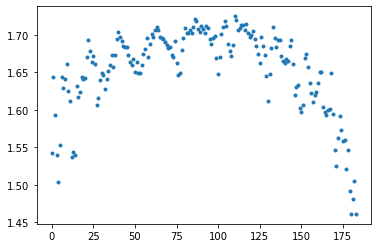

In [6]:
plt.plot(np.asarray(roughnesses),'.')

<Figure size 1080x1080 with 0 Axes>

<AxesSubplot:>

Text(0.5, 1.0, 'roughness')

<AxesSubplot:>

Text(0.5, 1.0, 'volume')

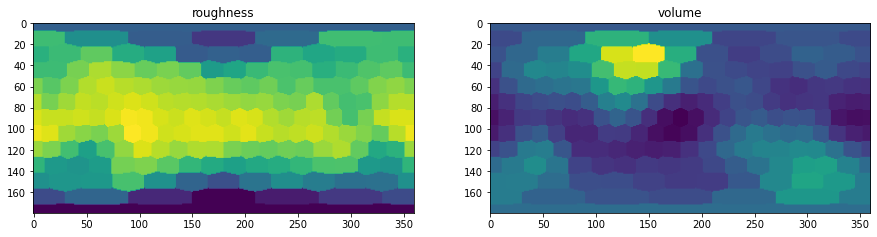

In [7]:
# show the map of roughness
plt.figure(figsize=(15,15))
plt.subplot(121)
plt.imshow(roughnesses_map);plt.title('roughness')
plt.subplot(122)
plt.imshow(conevolumes_map);plt.title('volume')